🌱 Global random seed set to 42
Epoch 1/800


/usr/workspace/dhakal1/dev/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-13 15:24:15.775212: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be 

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3645 - mape: 533.2286 - val_loss: 0.1297 - val_mape: 121.3361 - learning_rate: 5.0000e-04
Epoch 2/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2570 - mape: 480.3384 - val_loss: 0.1304 - val_mape: 129.3091 - learning_rate: 5.0000e-04
Epoch 3/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2086 - mape: 362.6277 - val_loss: 0.1302 - val_mape: 102.9530 - learning_rate: 5.0000e-04
Epoch 4/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1986 - mape: 270.3899 - val_loss: 0.1288 - val_mape: 98.5657 - learning_rate: 5.0000e-04
Epoch 5/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1884 - mape: 367.6371 - val_loss: 0.1279 - val_mape: 98.7870 - learning_rate: 5.0000e-04
Epoch 6/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1687 - mape: 481.3954 - val_loss: 0.1311 - val_mape: 124.9647 - learning_rate: 5.0000e-04
Epoch 7/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1591 - mape: 278.9437 - val_loss: 0.1307 - val

2026-01-13 15:24:23.914620: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


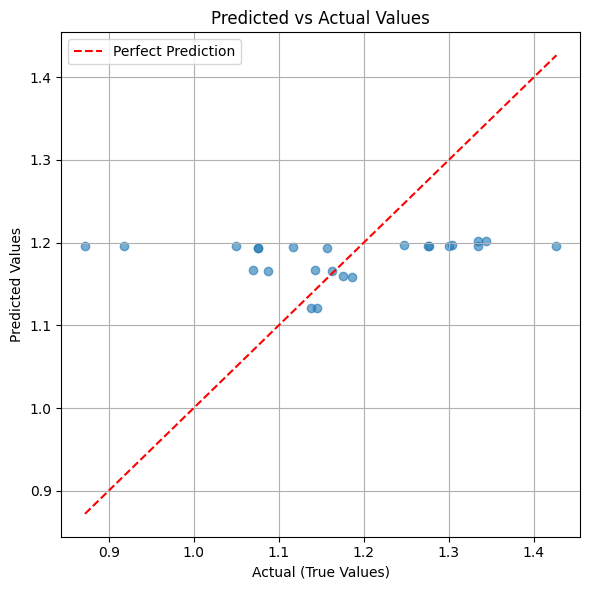

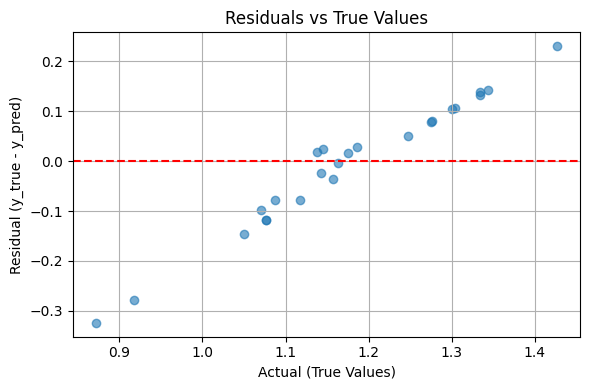

In [9]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers


# ----------------------------
# 1️ Reproducibility
# ----------------------------
def set_global_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f"🌱 Global random seed set to {seed}")


# ----------------------------
# 2️ Model Definition
# ----------------------------
def build_model(input_dim, learning_rate=0.0005):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.2),

        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.2),

        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mape'])
    return model


# ----------------------------
# 3️ Training Function
# ----------------------------
def train_nn_regressor(train_csv, test_csv=None, target_column="target",
                       use_split=False, seed=42):
    set_global_seed(seed)

    # --- Load data ---
    df_train = pd.read_csv(train_csv)
    if test_csv:
        df_test = pd.read_csv(test_csv)
    elif use_split:
        df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=seed)
    else:
        raise ValueError("Either provide a test CSV or set use_split=True.")

    # --- Fill NaNs ---
    df_train = df_train.fillna(df_train.mean(numeric_only=True))
    df_test = df_test.fillna(df_test.mean(numeric_only=True))

    # --- Split X and y ---
    X_train = df_train.drop(columns=[target_column]).values
    y_train = df_train[target_column].values.reshape(-1, 1)
    X_test = df_test.drop(columns=[target_column]).values
    y_test = df_test[target_column].values.reshape(-1, 1)

    # --- Scale features ---
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    # --- Scale target (-1, 1) ---
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # --- Build model ---
    model = build_model(X_train.shape[1], learning_rate=0.0005)

    # --- Callbacks ---
    early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

    # --- Train ---
    history = model.fit(
        X_train, y_train_scaled,
        validation_data=(X_test, y_test_scaled),
        epochs=800,
        batch_size=32,
        verbose=1,
        callbacks=[early_stop, reduce_lr]
    )

    # --- Predict & inverse-transform ---
    y_pred_scaled = model.predict(X_test).reshape(-1, 1)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test_scaled)

    # --- Metrics ---
    mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
    mae = mean_absolute_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)

    print(f"\n Final Test MAPE: {mape:.3f}%")
    print(f" Mean Absolute Error (MAE): {mae:.5f}")
    print(f" R² Score: {r2:.4f}")

    # --- Visualization ---
    plot_results(y_test_original, y_pred)

    return model, history, (mape, mae, r2), (y_test_original, y_pred)


# ----------------------------
# 4️ Visualization
# ----------------------------
def plot_results(y_true, y_pred):
    # --- Predicted vs Actual ---
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual (True Values)")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Residual Plot ---
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Residuals vs True Values")
    plt.xlabel("Actual (True Values)")
    plt.ylabel("Residual (y_true - y_pred)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ----------------------------
# 5️ Example Usage
# ----------------------------
model, history, metrics, (y_true, y_pred) = train_nn_regressor(
    test_csv="../XSBenchOutput.csv",
    train_csv="../XSBench_CTGAN.csv",
    target_column="relative_runtime",
    seed=42
)

2025-11-07 12:58:32.504932: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 12:58:32.702796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762549112.771218 2484474 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762549112.790063 2484474 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-07 12:58:32.996046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

🌱 Global random seed set to 42
Epoch 1/800


/g/g90/dhakal1/All/dev/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-07 12:58:36.111856: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-07 12:58:36.242674: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_c

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step - loss: 0.2523 - mape: 237.2407 - val_loss: 0.2519 - val_mape: 101.1841 - learning_rate: 5.0000e-04
Epoch 2/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3004 - mape: 156.7564 - val_loss: 0.2229 - val_mape: 79.6454 - learning_rate: 5.0000e-04
Epoch 3/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2170 - mape: 191.9788 - val_loss: 0.1890 - val_mape: 60.0415 - learning_rate: 5.0000e-04
Epoch 4/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2218 - mape: 88.6114 - val_loss: 0.1667 - val_mape: 54.4462 - learning_rate: 5.0000e-04
Epoch 5/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2325 - mape: 149.5131 - val_loss: 0.1570 - val_mape: 58.5739 - learning_rate: 5.0000e-04
Epoch 6/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2754 - mape: 169.0815 - val_loss: 0.1543 - val_mape: 60.5580 - learning_rate: 5.0000e-04
Epoch 7/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2228 - mape: 210.0517 - val_loss: 0.1525 - val_mape: 61.3

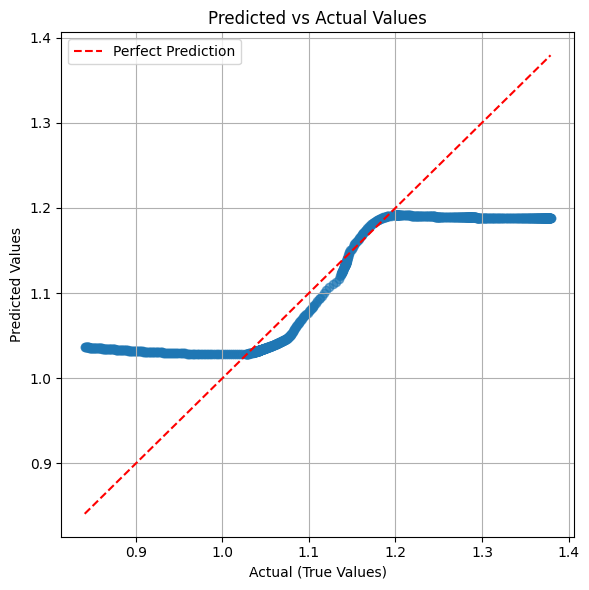

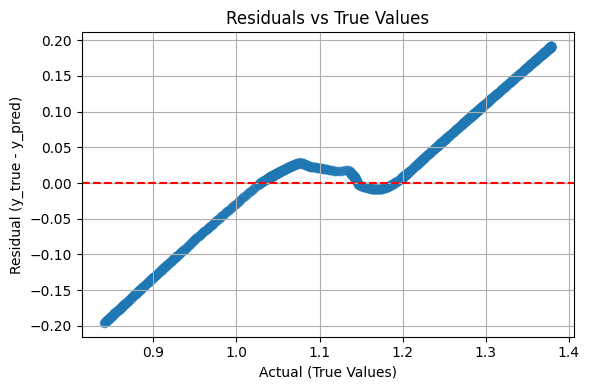

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers


# ----------------------------
# 1️ Reproducibility
# ----------------------------
def set_global_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f"🌱 Global random seed set to {seed}")


# ----------------------------
# 2️ Model Definition
# ----------------------------
def build_model(input_dim, learning_rate=0.0005):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.2),

        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.2),

        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mape'])
    return model


# ----------------------------
# 3️ Training Function
# ----------------------------
def train_nn_regressor(train_csv, test_csv=None, target_column="target",
                       use_split=False, seed=42):
    set_global_seed(seed)

    # --- Load data ---
    df_train = pd.read_csv(train_csv)
    if test_csv:
        df_test = pd.read_csv(test_csv)
    elif use_split:
        df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=seed)
    else:
        raise ValueError("Either provide a test CSV or set use_split=True.")

    # --- Fill NaNs ---
    df_train = df_train.fillna(df_train.mean(numeric_only=True))
    df_test = df_test.fillna(df_test.mean(numeric_only=True))

    # --- Split X and y ---
    X_train = df_train.drop(columns=[target_column]).values
    y_train = df_train[target_column].values.reshape(-1, 1)
    X_test = df_test.drop(columns=[target_column]).values
    y_test = df_test[target_column].values.reshape(-1, 1)

    # --- Scale features ---
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    # --- Scale target (-1, 1) ---
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # --- Build model ---
    model = build_model(X_train.shape[1], learning_rate=0.0005)

    # --- Callbacks ---
    early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

    # --- Train ---
    history = model.fit(
        X_train, y_train_scaled,
        validation_data=(X_test, y_test_scaled),
        epochs=800,
        batch_size=32,
        verbose=1,
        callbacks=[early_stop, reduce_lr]
    )

    # --- Predict & inverse-transform ---
    y_pred_scaled = model.predict(X_test).reshape(-1, 1)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test_scaled)

    # --- Metrics ---
    mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
    mae = mean_absolute_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)

    print(f"\n Final Test MAPE: {mape:.3f}%")
    print(f" Mean Absolute Error (MAE): {mae:.5f}")
    print(f" R² Score: {r2:.4f}")

    # --- Visualization ---
    plot_results(y_test_original, y_pred)

    return model, history, (mape, mae, r2), (y_test_original, y_pred)


# ----------------------------
# 4️ Visualization
# ----------------------------
def plot_results(y_true, y_pred):
    # --- Predicted vs Actual ---
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual (True Values)")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Residual Plot ---
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Residuals vs True Values")
    plt.xlabel("Actual (True Values)")
    plt.ylabel("Residual (y_true - y_pred)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ----------------------------
# 5️ Example Usage
# ----------------------------
model, history, metrics, (y_true, y_pred) = train_nn_regressor(
    train_csv="output_quartz(ruby)_XSBench.csv",
    test_csv="/g/g90/dhakal1/All/MIN_example/generated_cycles(XSBench)/generated_cycle_1.csv",
    target_column="relative_runtime",
    seed=42
)